# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 6. Основы обработки текстов


**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*


**Баллы за задание:**

* Задача 1 &mdash; 100 баллов
* Задача 2 &mdash; 50 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [1]:
# Bot check

# HW_ID: fpmi_ad6
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [2]:
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from string import punctuation
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torchtext
from torchtext.data.utils import get_tokenizer

import seaborn as sns

sns.set(palette="Set2")
sns.set_style("whitegrid")

import nltk

nltk.download("stopwords")

device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available() else "cpu"
)
device

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


'cuda'

In [3]:
import textwrap
import copy

Перед выполнением задания обязательно посмотрите <a href="https://miptstats.github.io/courses/ad_fivt/lecture6.pdf" target="_blank">презентацию</a>, [ноутбук](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html) по RNN и [ноутбук](https://miptstats.github.io/courses/ad_fivt/nlp_sem_llama.html) по генерации текста.

---
### Задача 1. Предсказание заработной платы


В этой задаче вам предлагается решить задачу регрессии &mdash; по текстовому описанию вакансии определить заработную плату. Для решения такой задачи можно применять различные методы, в том числе и те, которые были рассмотрены на лекции.
Мы будем решать эту задачу с помощью рекуррентной нейронной сети.

Датасет `salary_dataset.csv` лежит по <a target="_blank" href="https://drive.google.com/file/d/1Q3lCw_8Uad_OzHCjvLeYRvamXR74UPbW/view?usp=sharing">ссылке</a> (312.3 MB).

Если вы работаете локально:

> Просто скачайте этот файл и укажите пути к ним ниже.


Если вы используете <a target="_blank" href="https://colab.research.google.com/">Colab</a>:
> **Скачивать файл не обязательно**. Просто подключитесь к Google Drive:
>
> ```
> from google.colab import drive
> drive.mount('/content/drive/')
> ```
>
> Перейдите по ссылке файла и добавьте shortcut на него в ваш собственный диск:
> 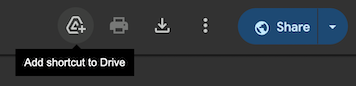

Подключим Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Скачаем данные для обучения и тестирования:

In [5]:
dataset = pd.read_csv("/content/drive/MyDrive/mipt-stats/salary_dataset.csv")
dataset.head()

,FullDescription,SalaryNormalized
0,This is an exciting opportunity for a Recruite...,55000
1,Our client is looking for a .net web developer...,27500
2,"MS SQL Database Administrator Helsinki, Finla...",72098
3,ACADEMIC APPOINTMENTS A large secondary school...,32400
4,Head of User Experience c. ****k / London A H...,67500


Каждая строка содержит полное описание вакансии и соответствующую зарплату. При этом описания могут быть довольно длинными, например:

In [6]:
dataset.iloc[0]["FullDescription"]

'This is an exciting opportunity for a Recruiter to join a rapidly growing online retailer. You will be responsible for developing and executing recruiting plans across the company. Your key accountabilities will include creating job descriptions, working closely with hiring managers, reducing recruitment costs, coordinating and implementing university recruitment initiatives and networking with industry contacts. You should be of graduate calibre with a track record in recruitment ideally gained in a fast moving start up environment. Experience of working in an online company would be a distinct advantage. Our client is an online retailer operating in the UK and in Continental Europe. This job was originally posted as www.totaljobs.com/JobSeeking/RecruitmentManager_job****'

Для данной задачи нам не будут нужны служебные части речи и знаки пунктуации. Зададим токенизатор, списки стоп-слов и пунктуации.

In [7]:
# Зададим токенизаторы
tokenizer = get_tokenizer("spacy", language="en_core_web_sm")
stop_words = nltk.corpus.stopwords.words("english")  # стоп-слова
punc = list(punctuation)  # пунктуация

Подготовьте словарь, оставив в нем только наиболее часто встречающиеся токены. Не забудьте предварительно убрать из предложений знаки пунктуации и стоп-слова.

*Можно использовать код с [семинара](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html).*

Так как мне не нравится как реализован код семинара по нескольким причинам:

====================================<br>
Будем работать немного по-другому

Разделим данные на обучающую и валидационную выборку

In [8]:
train_dataset, valid_dataset = train_test_split(dataset)  # Обучающая и тестовая выборки, тестовую выборку менять не будем

print(f"Размер train: {len(train_dataset)}, Размер valid: {len(valid_dataset)}")

Размер train: 150000, Размер valid: 50000


Изменим регистр текстов обучающей выборки на нижний, хоть токенайзер и преобразовывет текст к нижнему регистру, но при составлении словаря мы проверяем принадлежность **слова** (не токена) к множеству стоп-слов

In [9]:
train_dataset["FullDescription"] = train_dataset["FullDescription"].str.lower()

Используем код с семинара для подсчёта слов

In [10]:
# зададим счетчики
counter = Counter()

# посчитаем количество вхождений каждого токена
for _, row in train_dataset.iterrows():
    counter.update(
        token
        for token in tokenizer(row["FullDescription"])
        if token not in stop_words and token not in punc
    )

ordered_dict = OrderedDict(counter)

Теперь посмотрим какой размер словаря необходимо взять, чтобы слова в нём использовались хотя бы 1% от числа текстов раз.

In [11]:
print(counter.most_common()[25000])

('reinspections', 11)


При размере словаря равным 25,000 слов, мы включаем все слова, которые используются в обучающей выборке больше 20 раз. Сделаем размер словаря таким, так как 20 <<  150,000 (Размер обучающей выборки), т.е. слова не попадающие в словарь используются менее чем в 0.02% случаев

In [12]:
MAX_VOCAB_SIZE = 25000  # ограничение на словарь
ordered_dict = OrderedDict(counter.most_common(MAX_VOCAB_SIZE))

Этот упорядоченный словарь хранит слово и его встречаемость. Можно посмотреть на самые частые слова в датасете:

In [13]:
list(ordered_dict.items())[:10]

[(' ', 498177),
 ('experience', 260946),
 ('role', 178963),
 ('work', 170856),
 ('team', 163622),
 ('business', 162370),
 ('skills', 143863),
 ('working', 136519),
 ('within', 133474),
 ('sales', 127867)]

Видим, что в словаре есть токен пробела, это произошло потому, что токенизатор убирает только одинарные пробелы, добавим двойной пробел в список стопслов и убёрем пробел из словаря

In [14]:
stop_words.append('  ')
ordered_dict.pop('  ');

Проверим, что среди первых 30 слов, нет таких же ошибок, которые присутствуют в большом числе текстов

In [15]:
list(ordered_dict.items())[9:60]

[('sales', 127867),
 ('client', 120692),
 ('management', 114000),
 ('manager', 112675),
 ('company', 107339),
 ('please', 104912),
 ('development', 99330),
 ('looking', 95710),
 ('job', 94243),
 ('support', 93508),
 ('excellent', 88169),
 ('service', 85071),
 ('required', 82934),
 ('opportunity', 80523),
 ('new', 78492),
 ('must', 76749),
 ('recruitment', 72492),
 ('successful', 71534),
 ('knowledge', 69035),
 ('uk', 68946),
 ('apply', 68737),
 ('customer', 68357),
 ('based', 66011),
 ('services', 64059),
 ('ability', 62937),
 ('strong', 61266),
 ('ensure', 59725),
 ('candidate', 58798),
 ('project', 58196),
 ('high', 57785),
 ('join', 57762),
 ('salary', 56697),
 ('training', 56439),
 ('environment', 56092),
 ('care', 55786),
 ('design', 55459),
 ('including', 54942),
 ('good', 54865),
 ('leading', 54821),
 ('clients', 54333),
 ('also', 54296),
 ('able', 54243),
 ('cv', 53362),
 ('technical', 53123),
 ('position', 52705),
 ('well', 52333),
 ('key', 50721),
 ('candidates', 50341),
 ('e

Всё остальное выглядит хорошо

Теперь изменим словарь, добавив в него специальные токены, которые необходимы для подготовки данных к обучению:

In [16]:
# зададим словарь
vocab = torchtext.vocab.vocab(ordered_dict)

unk_token = "<unk>"
pad_token = "<pad>"


def add_special_tokens(vocab):
    """Функция для добавления специальных токенов в словарь."""
    for special_token in [unk_token, pad_token]:
        vocab.append_token(special_token)
    vocab.set_default_index(vocab[unk_token])
    UNK_IDX = vocab[unk_token]
    PAD_IDX = vocab[pad_token]
    return vocab, UNK_IDX, PAD_IDX


vocab, UNK_IDX_EN, PAD_IDX_EN = add_special_tokens(vocab)
num_tokens = len(vocab)

Подготовим класс датасета:

In [17]:
class SalaryPredictionDataset(Dataset):
    """Класс датасета для предсказания зарплаты"""

    def __init__(self, texts, target):
        """
        Параметры.
        1) texts (list) — корпус токенизированных текстов, на котором будет
                          происходить обучение
        2) labels (list) — истинные метки текстов
        """
        self.texts = texts
        self.target = target

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return self.texts[idx], self.target[idx]

Допишите функцию для дополнения текста до максимальной длины в батче. Снова воспользуйтесь кодом с [семинара](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html).

*Обратите внимание, что теперь вместо целочисленных меток мы используем вещественные таргеты. Если не поменять код с семинара, то вы можете решать неправильную задачу.*

Изменим тип таргета на FloatTensor

In [18]:
def pad_collate(batch):
    """
    Формирует тензоры из токенизированных текстов и таргетов, а также
    дополняет последовательности токенов до макс. длины в батче с UNK_IDX

    Вход:
    * batch — батч с текстами и таргетами

    Возвращает:
    * texts_tensors - список тензоров текстов из батча, дополненных паддингом
    * target - список соответствующих меток батча
    """
    texts, target = zip(*batch)

    # сформируем тензоры
    texts_tensors = [torch.LongTensor(t) for t in texts]
    target = torch.FloatTensor(target)  # Изменим тип тензора на float
    # дополним до макс. длины в батче
    texts_tensors = pad_sequence(
        texts_tensors, padding_value=PAD_IDX_EN, batch_first=True
    )

    return texts_tensors, target

Токенизируем текст, а таргет переведем во `float`.

Не будем использовать предложенный код по двум причинам: первая - он не убирает токены стоп-слов и вместо них просто подставляет '\<unc\>' (так как этих слов нет в словаре) и вторая - текст берётся из dataset, т.е. он не приведён к нижнему регистру.<br>
Вместо этого напишем функцию преобразования текста и зарплаты

In [19]:
# tokens = [vocab(tokenizer(text)) for text in dataset["FullDescription"]]
# target = [float(value) for value in dataset["SalaryNormalized"]]


def data_transform(data):

  tokens = [[] for _ in range(len(data))]
  target = [float(value) for value in data["SalaryNormalized"]]

  for i in range(len(data)):
    for token in tokenizer(data["FullDescription"].iloc[i]):
      if (token not in stop_words and token not in punc):
        tokens[i].append(vocab([token])[0])

  return tokens, target

Токенизируем обучающую выборку

In [20]:
train_tokens, train_target = data_transform(train_dataset)

Каждому из текстов в датасете сопоставляется последовательность токенов, причем везде разного размера:

In [21]:
train_dataset["FullDescription"].iloc[0]

'our prestigious oil and gas client is currently seeking a lead project accountant to join their team. your role will involve: supervision of the accounting team. ensuring monthly client invoices are prepared in accordance with the commercial terms of the contract. performing / reviewing project month end closeout ensuring all accounting entries (revenue and cost accruals) are processed in time for period close. reporting financial performance to senior management including variance, accounts receivables, accruals and unbilled analysis. review and analysis of project overheads. calculation of project standard rates for offshore personnel. preparation of annual budget and quarterly reforecast in conjunction with project management. responding to monthly queries raised by the client. preparation of monthly cash flow forecasts for treasury department and monitoring of project accounts receivables. liaising with external, internal and client auditors.'

In [22]:
for i in range(3):
    print(f"Количество токенов в {i}-м тексте - {len(train_tokens[i])}:\n  ", end="")
    for token in train_tokens[i][:10]:
        print(token, end=", ")
    print("...\nТаргет:", train_target[i], "\n")

Количество токенов в 0-м тексте - 92:
  879, 992, 684, 10, 105, 193, 149, 37, 750, 39, ...
Таргет: 40000.0 

Количество токенов в 1-м тексте - 149:
  136, 12, 9, 175, 192, 40, 219, 534, 31, 24999, ...
Таргет: 18000.0 

Количество токенов в 2-м тексте - 168:
  59, 3090, 703, 12, 114, 558, 6300, 572, 0, 576, ...
Таргет: 25000.0 



При решении задач регрессии с помощью нейросетей удобнее всего бывает перевести предсказываемые значения в небольшой диапазон, например, от 0 до 1. Это нужно, чтобы повысить численную стабильность обучения &mdash; не нагружать модель большими значениями таргетов. В нашей задаче это важно, ведь зарплата может иметь большой разброс и принимать большие значения.

Чтобы сделать это, воспользуемся преобразованием `MinMaxScaler` из библиотеки `sklearn`, которое мы рассматривали в [задаче 3 задания 3](https://miptstats.github.io/courses/ad_fivt/task3.html#%D0%97%D0%B0%D0%B4%D0%B0%D1%87%D0%B0-3.).
Таким образом, мы получим значения, удобные для использования при обучении.

Разбивать данные нет необходимости, это уже было проделано

In [23]:
# train_tokens, valid_tokens, train_target, valid_target = train_test_split(
#     tokens, target
# )

# Преобразуем валидационные данные
valid_data = copy.deepcopy(valid_dataset)
valid_data["FullDescription"] = valid_data["FullDescription"].str.lower()
valid_tokens, valid_target = data_transform(valid_data)

scaler = MinMaxScaler()
train_target_std = scaler.fit_transform(np.array(train_target).reshape(-1, 1))
valid_target_std = scaler.transform(np.array(valid_target).reshape(-1, 1))

train_data = SalaryPredictionDataset(train_tokens, train_target_std)
valid_data = SalaryPredictionDataset(valid_tokens, valid_target_std)
len(train_data), len(valid_data)

(150000, 50000)

Посмотрим на отмасштабированные значения зарплаты:

In [24]:
print("Преобразованные таргеты:")
for t in train_data[:3][1]:
    print(round(t.item(), 4), end=", ")
print("...")

Преобразованные таргеты:
0.1795, 0.0667, 0.1026, ...


Сформируйте даталоадеры для обучения и валидации.

In [25]:
BATCH_SIZE = 64  # размер батча

# сформируем даталоадеры
train_loader = DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate
)

valid_loader = DataLoader(
    valid_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_collate
)

Наконец, можем подготовить модель. Будем использовать рекуррентную архитектуру, подобную той, что была на [семинаре](https://miptstats.github.io/courses/ad_fivt/nlp_sem.ipynb).
Отличие состоит в том, что теперь мы предсказываем не метку класса, а вещественный таргет. Подумайте, какую часть сети нужно изменить, чтобы адаптировать ее к нашей задаче.

Так как в семинаре было предсказание метки класса использовалось 2 логита и выход был размерности 2. У нас выход размерности 1, поэтому необходимо преобразовать предсказание в одномерный тензор. Также будем использовать нелинейный слой, для получения лучших результатов.

In [26]:
class SimpleRNNRegressor(nn.Module):
    """ 
    Модель для регрессии на основе LSTM
    RNN -> Linear -> Sigmoid -> Linear
    """
    

    def __init__(
        self,
        num_tokens,
        emb_size=512,
        rnn_num_units=64,
        rnn_num_layers=1,
        output_dim=1
    ):
        """
        1) num_tokens — общее количество токенов,
        2) emb_size — размер эмбеддингового пространства,
        3) rnn_num_units - размер пространства скрытых представлений в rnn,
        4) rnn_num_layers - число слоёв rnn,
        5) output_dim - размерность выхода-предсказания.
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size, padding_idx=PAD_IDX_EN)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.classifier = nn.Sequential(nn.Linear(rnn_num_units, rnn_num_units), nn.Sigmoid(), nn.Linear(rnn_num_units, output_dim))


    def forward(self, x):
        """
        * x — общее количество токенов.

        Возвращает:
        * predictions - предсказания модели.
        """
        emb = self.emb(x)

        _, (h_state, _) = self.rnn(emb)

        predictions = torch.squeeze(self.classifier(h_state.squeeze(0)))

        return predictions

Так как теперь решаем задачу регрессии, вместо точности модели будем измерять среднеквадратичную ошибку:

In [27]:
def mse(preds, y):
    """
    Возвращает среднеквадратичную ошибку модели.

    Параметры.
    1) preds — предсказания модели,
    2) y — истинные значения таргета.
    """

    return F.mse_loss(preds, y, reduction="mean")

Допишите функции для обучения и валидации. Они почти не будут отличаться от тех, что были на [семинаре](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html).

In [104]:
def train(model, iterator, optimizer, criterion, train_loss_history):
    """
    Функция для обучения модели на обучающем датасете и подсчёта
    её ошибки.

    Параметры.
    1) model — модель,
    2) iterator — итератор обучающего датасета,
    3) optimizer — класс метода оптимизации,
    4) criterion — функция потерь.
    """
    epoch_loss = 0
    epoch_mse = 0
    model.train()

    # Проход по всему датасету
    for batch_id, batch in enumerate(iterator):
        # Обучение на 1 батче, подсчет метрики
        # чтобы градиент не накапливался, его нужно обнулить
        optimizer.zero_grad()
        # получим предсказания модели
        texts, labels = batch
        texts, labels = texts.to(device), labels.to(device)
        predictions = model(texts)
        labels = torch.squeeze(labels)
        loss = criterion(predictions, labels)
        mse_error = mse(predictions, labels)
        # сделаем back-propagation для подсчёта градиентов
        loss.backward()
        # выполним шаг оптимизатора
        optimizer.step()
        # обновим метрики
        epoch_loss += loss.item()
        epoch_mse += mse_error.item()
        train_loss_history.append(loss.item())

    return epoch_loss / len(iterator), epoch_mse / len(iterator)


def evaluate(model, iterator, criterion, val_loss_history=None):
    """
    Функция для применения модели на валидационном/тестовом датасете и подсчёта
    её точности.

    Параметры.
    1) model — модель,
    2) iterator — итератор датасета,
    3) criterion — функция потерь.
    """
    epoch_loss = 0
    epoch_mse = 0

    model.eval()

    with torch.no_grad(): # отключим подсчёт градиентов на валидации
        # Проход по всему датасету
        for batch_id, batch in enumerate(iterator):
            # Обучение на 1 батче, подсчет метрики
            texts, labels = batch
            texts, labels = texts.to(device), labels.to(device)
            labels = torch.squeeze(labels)
            # получим предсказания
            predictions = model(texts)
            # посчитаем метрики
            loss = criterion(predictions, labels)
            mse_error = mse(predictions, labels)
            # обновим метрики
            epoch_loss += loss.item()
            epoch_mse += mse_error.item()
            if val_loss_history is not None:
                val_loss_history.append(loss.item())

    return epoch_loss / len(iterator), epoch_mse / len(iterator)


def epoch_time(start_time, end_time):
    """
    Функция для подсчёта времени работы одной эпохи.

    Параметры.
    1) start_time — время начала запуска,
    2) end_time — время завершения работы эпохи.
    """

    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Теперь определим итоговую функцию для всего цикла обучения:

In [105]:
def visualize_epoch(epoch, start_time, loss_history, mse_history):
    """
    Функция для визуализации 1 эпохи.

    Параметры.
    1) epoch — номер эпохи,
    2) start_time — время начала эпохи,
    3) loss_history - tuple истории лосса на train и test,
    4) mse_history - tuple истории MSE на train и test.
    """
    # Посчитаем время работы одной эпохи
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # Отобразим графики лоссов
    clear_output(True)
    plt.figure(figsize=(18, 6))

    train_loss_history, val_loss_history = loss_history
    plt.subplot(1, 3, 1)
    plt.plot(train_loss_history)
    plt.title("Train Loss")
    plt.xlabel("Номер батча")
    plt.subplot(1, 3, 2)
    plt.plot(val_loss_history, color="tab:orange")
    plt.title("Valid Loss")
    plt.xlabel("Номер батча")

    # Отрисуем значение MSE от эпохи
    train_mse_history, val_mse_history = mse_history
    plt.subplot(1, 3, 3)
    plt.plot(train_mse_history, label="Train")
    plt.plot(val_mse_history, label="Valid")
    plt.legend()
    plt.title("MSE")
    plt.xlabel("Номер эпохи")
    plt.show()

    print(
      f"Номер эпохи: {epoch+1:02} | Время обучения эпохи: {epoch_mins}m {epoch_secs}s, MSE: {val_mse_history[-1]:.5f}"
    )



def training_loop(model_instance, n_epochs=10):
    """
    Функция для обучения нейронной сети.

    Параметры.
    1) model_instance — обучаемая модель,
    2) n_epochs — количество эпох.
    """

    best_valid_loss = float("inf")
    train_loss_history = []
    val_loss_history = []
    train_mse_history = []
    val_mse_history = []
    for epoch in range(n_epochs):
        start_time = time.time()
        # Обучим одну эпоху на обучающем датасете
        train_loss, train_mse = train(
            model_instance,
            train_loader,
            optimizer,
            criterion,
            train_loss_history,
        )
        train_mse_history.append(train_mse)

        # Оценим ошибку модели на тестовом датасете
        valid_loss, valid_mse = evaluate(
            model_instance, valid_loader, criterion, val_loss_history
        )
        val_mse_history.append(valid_mse)

        # Если значение функции потерь улучшилось, сохраним параметры модели
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model_instance.state_dict(), "model_checkpoint.pt")

        # Визуализируем результаты эпохи
        visualize_epoch(
            epoch,
            start_time,
            (train_loss_history, val_loss_history),
            (train_mse_history, val_mse_history)
        )

Возьмём 1-слойную RNN

In [106]:
# Задайте параметры сети
model1 = SimpleRNNRegressor(
    num_tokens=num_tokens,
    emb_size=100,
    rnn_num_units=64,
    rnn_num_layers=1,
    output_dim=1,
).to(device)


# У нас задача регрессии, будем использовать MSELoss
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)
history = []

# Посмотрите на получившуюся модель
model1

SimpleRNNRegressor(
  (emb): Embedding(25001, 100, padding_idx=25000)
  (rnn): LSTM(100, 64, batch_first=True)
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

Обучите несколько моделей с различными гиперпараметрами (например, шаг обучения, размер словаря, архитектура) и сравните их качество на тестовой выборке.

*Не пугайтесь, если у вас не будет получаться хорошее качество на валидации: решаемая задача довольно сложная, а RNN &mdash; достаточно простая архитектура. Но постарайтесь, чтобы модель хотя бы не вырождалась в константу. Для этого следите за переобучением!*

*На 3 курсе вы сможете познакомиться с моделями, которые решают такую задачу гораздо лучше.*

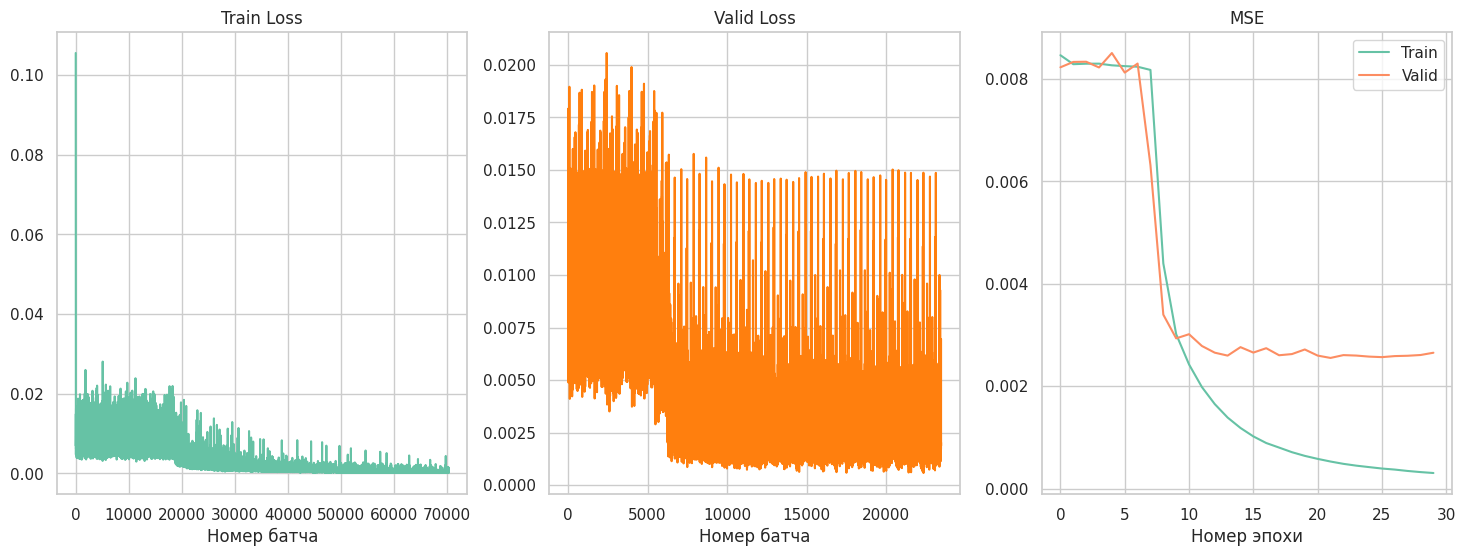

Номер эпохи: 30 | Время обучения эпохи: 0m 16s, MSE: 0.00265


In [107]:
training_loop(model1, 30)

Изменим количество слоёв RNN

In [108]:
model2 = SimpleRNNRegressor(
    num_tokens=num_tokens,
    emb_size=100,
    rnn_num_units=64,
    rnn_num_layers=2,
    output_dim=1,
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)
history = []

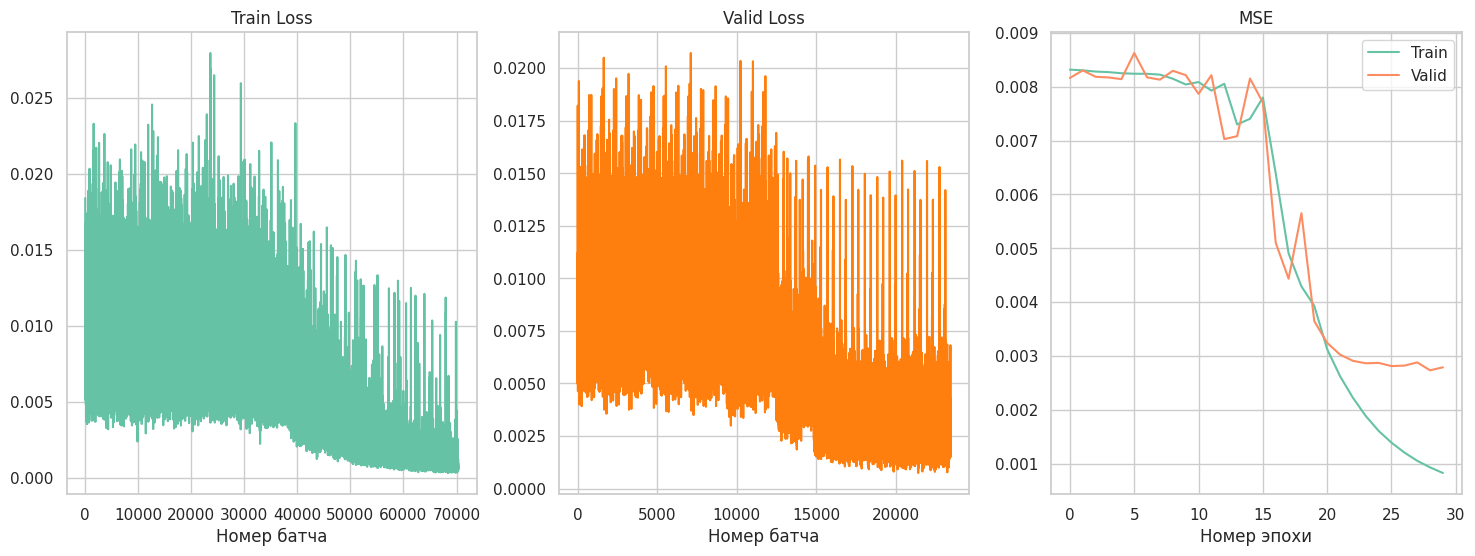

Номер эпохи: 30 | Время обучения эпохи: 0m 16s, MSE: 0.00279


In [109]:
training_loop(model2, 30)

4 слоя:

In [112]:
model3 = SimpleRNNRegressor(
    num_tokens=num_tokens,
    emb_size=200,
    rnn_num_units=64,
    rnn_num_layers=2,
    output_dim=1,
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.001)
history = []

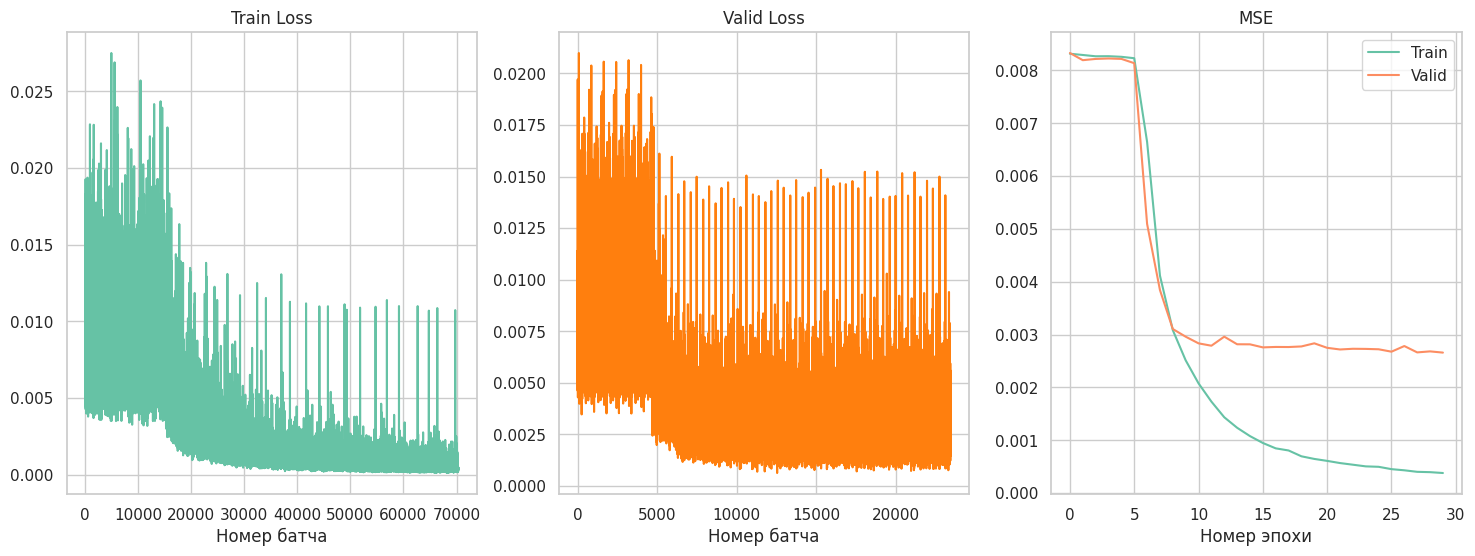

Номер эпохи: 30 | Время обучения эпохи: 0m 17s, MSE: 0.00266


In [113]:
training_loop(model3, 30)

Изменим теперь архитектуру модели, а именно слои после RNN

In [116]:
class SimpleRNNRegressor2(nn.Module):
    """
    Модель для регрессии на основе LSTM
    RNN -> Linear -> ReLU -> Linear
    """
    def __init__(
        self,
        num_tokens,
        emb_size=512,
        rnn_num_units=64,
        rnn_num_layers=2,
        output_dim=1
    ):

        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size, padding_idx=PAD_IDX_EN)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.classifier = nn.Sequential(nn.Linear(rnn_num_units, rnn_num_units), nn.ReLU(),
                                        nn.Linear(rnn_num_units, 16), nn.ReLU(), nn.Linear(16, output_dim))


    def forward(self, x):

        emb = self.emb(x)
        _, (h_state, _) = self.rnn(emb)
        predictions = torch.squeeze(self.classifier(h_state.squeeze(0)))

        return predictions

In [117]:
model4 = SimpleRNNRegressor2(
    num_tokens=num_tokens,
    emb_size=100,
    rnn_num_units=64,
    rnn_num_layers=1,
    output_dim=1,
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model4.parameters(), lr=0.001)
history = []

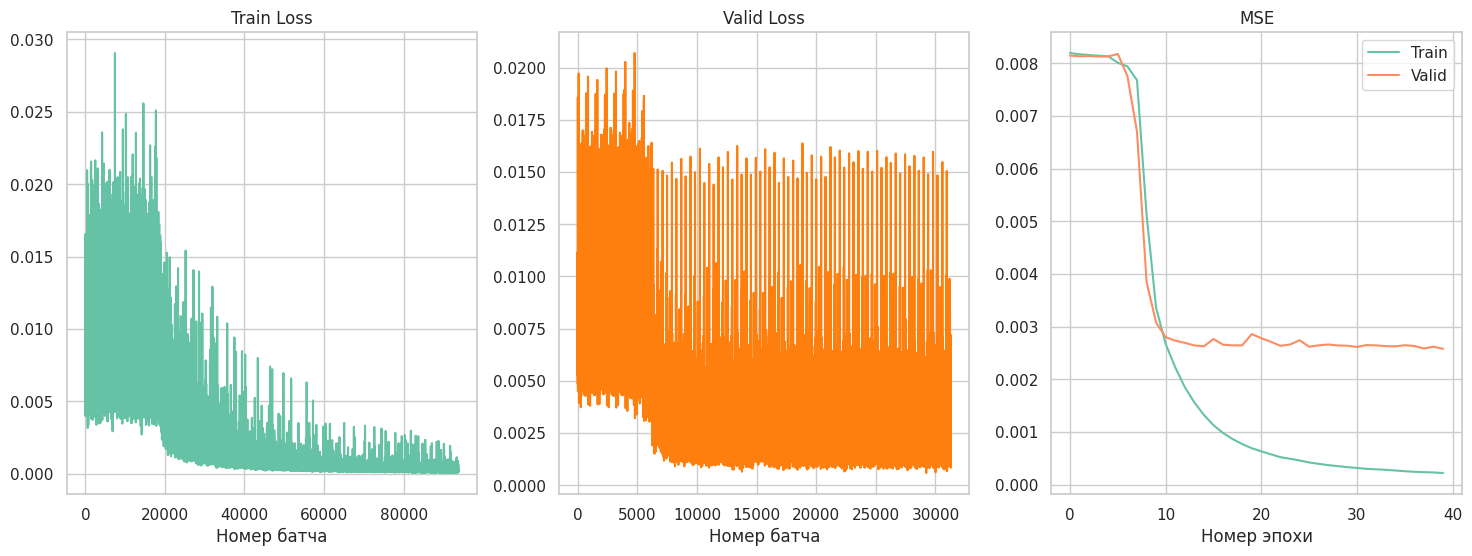

Номер эпохи: 40 | Время обучения эпохи: 0m 16s, MSE: 0.00258


In [118]:
training_loop(model4, 40)

Видим

In [119]:
model5 = SimpleRNNRegressor2(
    num_tokens=num_tokens,
    emb_size=100,
    rnn_num_units=64,
    rnn_num_layers=2,
    output_dim=1,
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model5.parameters(), lr=0.001)
history = []

SimpleRNNRegressor2(
  (emb): Embedding(25001, 100, padding_idx=25000)
  (rnn): LSTM(100, 64, batch_first=True)
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)

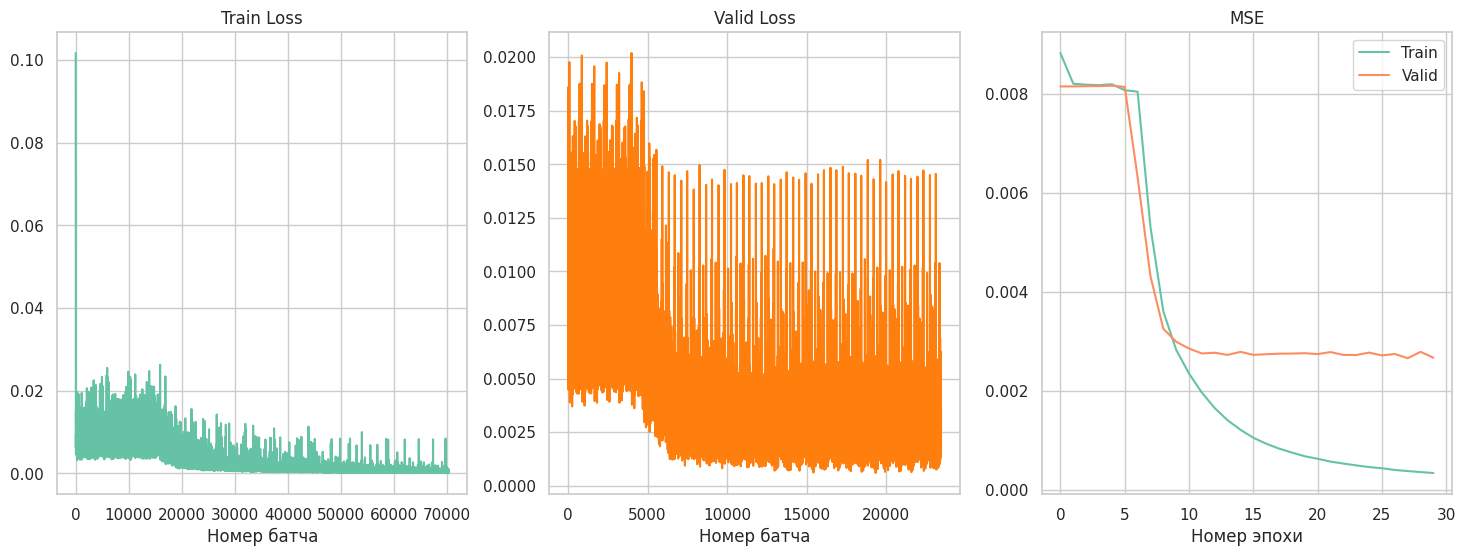

Номер эпохи: 30 | Время обучения эпохи: 0m 16s, MSE: 0.00267


In [120]:
training_loop(model5, 30)

Для всех моделей характерен резкий спад лосса после ~5 эпох,выход на плато после 10, а также в течении 30 эпох не было замечено переобучения.

Выведите несколько примеров работы на тестовой выборке: текст вакансии, предсказание вашей модели и истинное значение зарплаты. Чтобы вернуть все значения к изначальным масштабам, используйте `scaler.inverse_transform(...)`. Также посчитайте MSE на всей тестовой выборке.

Посчитаем MSE на всей выборке для каждой модели и выберем лучшую. Для этого проведём обратное преобразование зарплат и теперь также можно посчитать MAPE, тк не возникает проблем с делением на ноль

In [125]:
def mean_absolute_percentage_error(y_pred, y_true):
    return 100 * (np.abs(y_true - y_pred) / y_true).mean()

In [126]:
models = [model1, model2, model3, model4, model5]
for i, net in enumerate(models):
    total_mse = 0
    total_mape = 0
    total_rmse = 0
    net.eval()
    with torch.no_grad(): # отключим подсчёт градиентов на валидации
      # Проход по всему датасету
      for batch_id, batch in enumerate(valid_loader):

          texts, labels = batch
          texts, labels = texts.to(device), labels.to(device)
          labels = torch.squeeze(labels)

          preds = net(texts).cpu().reshape(-1, 1)
          preds = scaler.inverse_transform(preds)

          labels = scaler.inverse_transform(labels.cpu().reshape(-1, 1))

          labels = labels.squeeze(1)
          preds = preds.squeeze(1)



          mse_error = mse(torch.from_numpy(preds), torch.from_numpy(labels))
          mape_error = mean_absolute_percentage_error(preds, labels)
          rmse_error = np.sqrt(((labels - preds) ** 2).mean())
          total_rmse += rmse_error.item()
          total_mse += mse_error.item()
          total_mape += mape_error.item()

      print(f"Модель {i+1}:    MSE: {total_mse / len(valid_loader):,.0f}    RMSE: {total_rmse / len(valid_loader):.0f}   MAPE: {total_mape / len(valid_loader):.1f}%")

Модель 1:    MSE: 100,883,977,   RMSE: 9823,   MAPE: 19.0%
Модель 2:    MSE: 106,000,911,   RMSE: 10086,   MAPE: 21.0%
Модель 3:    MSE: 101,549,875,   RMSE: 9856,   MAPE: 20.1%
Модель 4:    MSE: 101,128,041,   RMSE: 9821,   MAPE: 20.0%
Модель 5:    MSE: 104,543,898,   RMSE: 9988,   MAPE: 20.2%
Модель 6:    MSE: 97,987,065,   RMSE: 9662,   MAPE: 19.1%
Модель 7:    MSE: 101,631,564,   RMSE: 9846,   MAPE: 19.5%
Модель 8:    MSE: 104,124,395,   RMSE: 9972,   MAPE: 20.1%
Модель 9:    MSE: 101,912,564,   RMSE: 9870,   MAPE: 19.7%


Видим что все модели дают очень похожие результаты причём все они являются достаточно неплохими со значение MAPE около 20%

Возьмем данные из валидационного датасета

In [127]:
sample = valid_dataset.sample(BATCH_SIZE)

Переведём в нижний регистр

In [171]:
smple = copy.deepcopy(sample)
smple["FullDescription"] = smple["FullDescription"].str.lower()

Преобразуем данные

In [172]:
descriptions, salaries = data_transform(smple);
ddd = SalaryPredictionDataset(descriptions, salaries)

new_loader = DataLoader(
    ddd, batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_collate
)

Применим модель, получим предсказания

In [173]:
data_batch, labels_batch = next(iter(new_loader))

# Применяем модель, получаем предсказания
with torch.no_grad():
    preds = model(data_batch.to(device)).cpu().reshape(-1, 1)
    preds = scaler.inverse_transform(preds)

Вывдем текст, предсказание и зарплату

In [174]:
print("Текст:")
a = sample["FullDescription"].iloc[0]
a = "\n".join(textwrap.wrap(a, 150))
print(a)

print(f"Предсказание модели: {round(preds[0][0])}")

salary = sample["SalaryNormalized"].iloc[0]
print(f"Зарплата: {salary}")

Текст:
We are looking for a Publications Planer for a **** month maternity leave cover contract to work at our Pavers Head Office in York. This is an
exciting opportunity to gain experience in a busy retail head office. You will assist in the layout of the Pavers catalogue, assigning products to
pages and creating catalogue descriptions. You will upload the layout plan and proof read the content ensuring all information is correct.
Responsibilities include ensuring that all products have accurate information and are featured in correct categories. You will supervise the upload of
images, descriptions and materials to the website. You will also liaise with the Company’s TV agency ensuring all products are uploaded and that all
information is sent and is accurate prior to filming.
Предсказание модели: 16346
Зарплата: 18000


In [175]:
print("Текст:")
a = sample["FullDescription"].iloc[1]
a = "\n".join(textwrap.wrap(a, 150))
print(a)

print(f"Предсказание модели: {round(preds[1][0])}")

salary = sample["SalaryNormalized"].iloc[1]
print(f"Зарплата: {salary}")

Текст:
An Outstanding Secondary School in central London is looking for a talented Science teaching assistant to join their successful Science department as
soon as possible. You will be required to work ****:**** and small group work within the Science department. This school was recently rated as
'Outstanding ' by Ofsted. It is an inspirational environment in which to work, boasting excellent facilities and supportive management and staff.
Please apply by sending your CV and details for contactable referee's as soon as possible. You are also welcome to contact Deon or Jenna on **** ****
**** to find out more about this role.
Предсказание модели: 26745
Зарплата: 16500


In [176]:
print("Текст:")
a = sample["FullDescription"].iloc[4]
a = "\n".join(textwrap.wrap(a, 150))
print(a)

print(f"Предсказание модели: {round(preds[4][0])}")

salary = sample["SalaryNormalized"].iloc[4]
print(f"Зарплата: {salary}")

Текст:
Lead Control Instrument Engineers required for Nuclear Power Stations on West East Coast of Scotland  contract and permanent vacancies available
contract positions are available for **** year with contract extension available. Immediate starts available Nuclear experience required Assistance
with security clearance provided This job was originally posted as www.totaljobs.com/JobSeeking/LeadControlInstrumentationEngineer_job****
Предсказание модели: 51210
Зарплата: 86400


**Вывод:**

Мы провели предобработку данных, а затем используя рекурсивные нейронные сети предсказали зарплату по текстовому описанию работы. Были протестированы несколько различных архитектур, но они отличались не больше чем на 2% по метрике MAPE. Все модели показали достаточно хорошие результаты (20% ошибка по MAPE, 10.000 по RMSE). Таким образом рекурсивные нейросети показали что они способны справялться с задачами, сформулированными на естественном для человека языке 

---
### Задача 2. Использование большой языковой модели


Задача2 выполнена в отдельном ноутбуке

**Вывод:**

---
*Если хотите отточить навык написания промптов &mdash; **prompt-engineering** &mdash; можете попробовать сыграть в <a target="_blank" href="https://gandalf.lakera.ai/">игру</a>. В ней нужно заставить Гендальфа выдать пароль. Со временем уровни становятся все сложнее и требуют более хитрых приемов.*